Log FilterBank Spectrogram

In [1]:
import os
import h5py
import torch
import librosa
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
from madmom.audio.filters import LogarithmicFilterbank
from madmom.audio.spectrogram import Spectrogram, LogarithmicFilteredSpectrogram
from madmom.audio.signal import Signal

def load_labels(excel_path):
    df = pd.read_excel(excel_path)
    labels = {row['Song Name']: row['Key'] for index, row in df.iterrows()}
    return labels

def get_log_filterbank_frequencies(sample_rate, frame_size, num_bands=24, fmin=65, fmax=2100):
    frequencies = np.fft.rfftfreq(frame_size, d=1/sample_rate)
    filt = LogarithmicFilterbank(frequencies, num_bands=num_bands, fmin=fmin, fmax=fmax)
    
    # 提取每個頻帶的中心頻率
    center_frequencies = filt.center_frequencies
    return center_frequencies


def compute_log_spectrogram(audio_path, sample_rate=48000, frame_size=8192, hop_size=9600):
    signal = Signal(audio_path, sample_rate=sample_rate, num_channels=1)  # 確保單通道
    spec = Spectrogram(signal, frame_size=frame_size, hop_size=hop_size)
    frequencies = np.fft.rfftfreq(frame_size, d=1/sample_rate)
    
    # 確保頻率數組與頻譜形狀匹配
    frequencies = frequencies[:spec.shape[-1]]
    
    # 初始化對數濾波器組
    filt = LogarithmicFilterbank(frequencies, num_bands=24, fmin=65, fmax=2100)
    
    # 應用濾波器並計算對數頻譜
    log_filt_spec = LogarithmicFilteredSpectrogram(spec, filterbank=filt)
    log_spec = np.log1p(log_filt_spec)
    
    # 調換維度，將時間維度放在最後
    log_spec = log_spec.T  # (時間, 頻率) -> (頻率, 時間)
    return log_spec


def plot_log_spectrogram(log_spec_normalized, center_frequencies, title='Log Spectrogram'):
    plt.figure()
    plt.imshow(log_spec_normalized[0].detach().numpy(), cmap='viridis', origin='lower', aspect='auto')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Frequency (Hz)')
    
    # 設置縱軸頻率標籤
    def format_func(value, tick_number):
        N = len(center_frequencies)
        index = int(value)
        if index >= 0 and index < N:
            return f'{int(center_frequencies[index])} Hz'
        else:
            return ''
    
    plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_func))
    plt.ylim([0, len(center_frequencies) - 1])
    plt.show()


def cyclic_pad_segment(segment, target_length):
    current_length = segment.shape[2]
    if current_length >= target_length:
        return segment[:, :, :target_length]
    else:
        repeat_count = (target_length // current_length) + 1
        padded_segment = segment.repeat(1, 1, repeat_count)
        return padded_segment[:, :, :target_length]


def save_log_spec_and_labels_to_hdf5(audio_paths, labels, hdf5_path):
    cnt = 0
    sample_rate = 48000
    frame_size = 8192
    hop_length = 8192

    center_frequencies = get_log_filterbank_frequencies(sample_rate, frame_size)
    
    with h5py.File(hdf5_path, 'w') as hf:
        for path in audio_paths:
            file_name = os.path.basename(path)
            waveform, sr = librosa.load(path, sr=sample_rate, mono=True)

            log_spec = compute_log_spectrogram(path, sample_rate=sample_rate, frame_size=frame_size, hop_size=hop_length)
            
            min_val = log_spec.min()
            max_val = log_spec.max()
            log_spec_normalized = (log_spec - min_val) / (max_val - min_val)
            log_spec_normalized = torch.from_numpy(log_spec_normalized).unsqueeze(0)
            print(f'file name: {file_name}')
            print(f'Log spectrogram shape: {np.shape(log_spec_normalized)}')

            label = labels[file_name]

            # 一個 30 秒片段包含片段數
            segment_frames = (sample_rate * 30) // hop_length
            num_segments = log_spec_normalized.shape[2] // segment_frames
            print(f'num_segments: {num_segments}')
            
            for i in range(num_segments):
                segment = log_spec_normalized[:, :, i*segment_frames : (i+1)*segment_frames]
                print(f'segment shape: {np.shape(segment)}')
                dataset_name = f"{file_name}_{i}"
                hf.create_dataset(dataset_name, data=segment.numpy())
                hf[dataset_name].attrs['label'] = label
                print(f'{dataset_name} label: {label}')

            # 如果片段不足 30 秒，进行循环填充
            if log_spec_normalized.shape[2] < segment_frames:
                padded_segment = cyclic_pad_segment(log_spec_normalized, segment_frames)
                print(f'padded segment shape: {np.shape(padded_segment)}')
                dataset_name = f"{file_name}_padded"
                hf.create_dataset(dataset_name, data=padded_segment.numpy())
                hf[dataset_name].attrs['label'] = label
                print(f'{dataset_name} label: {label} (循環填充)')
                if cnt < 3:
                    plot_log_spectrogram(padded_segment, center_frequencies, title=f'{file_name} Padded Log Spectrogram')

            if cnt < 3:
                plot_log_spectrogram(log_spec_normalized, center_frequencies)
            cnt += 1
        print(f'file_cnt = {cnt}')



In [2]:
import re

def numerical_sort(value):
    """
    通过文件名中的数字来排序
    """
    parts = re.split(r'(\d+)', value)
    parts[1::2] = map(int, parts[1::2])  # 将分割出来的数字部分转换为整数
    return parts

labels: {'instrument_estimated_1.wav': 'F# major', 'instrument_estimated_2.wav': 'B♭ minor', 'instrument_estimated_3.wav': 'F# major', 'instrument_estimated_4.wav': 'F# major', 'instrument_estimated_5.wav': 'F# major', 'instrument_estimated_6.wav': 'C# major', 'instrument_estimated_7.wav': 'F# major', 'instrument_estimated_8.wav': 'F# major', 'instrument_estimated_9.wav': 'B♭ minor', 'instrument_estimated_10.wav': 'F# major', 'instrument_estimated_11.wav': 'F# major', 'instrument_estimated_12.wav': 'C# major', 'instrument_estimated_13.wav': 'F# major', 'instrument_estimated_14.wav': 'B♭ minor', 'instrument_estimated_15.wav': 'C# major', 'instrument_estimated_16.wav': 'F# major', 'instrument_estimated_17.wav': 'F# major', 'instrument_estimated_18.wav': 'F# major', 'instrument_estimated_19.wav': 'C# major', 'instrument_estimated_20.wav': 'C# major', 'instrument_estimated_21.wav': 'F# major', 'instrument_estimated_22.wav': 'E♭ minor', 'instrument_estimated_23.wav': 'C# major', 'instrument

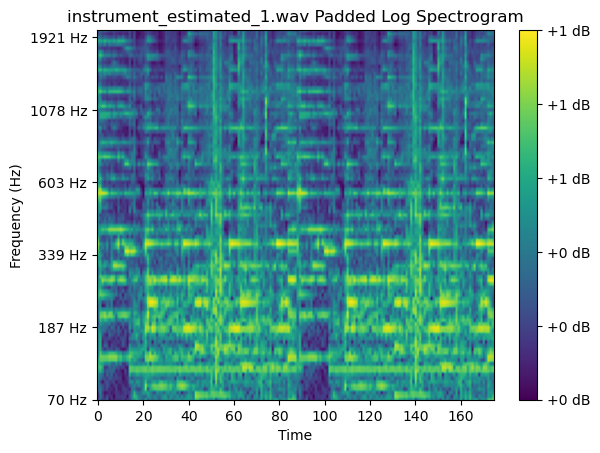

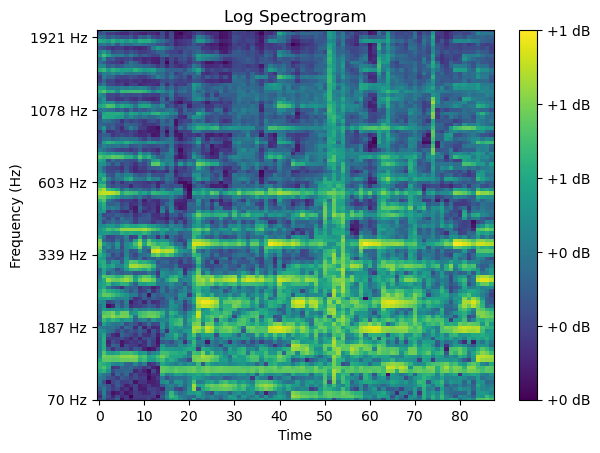

file name: instrument_estimated_2.wav
Log spectrogram shape: torch.Size([1, 103, 88])
num_segments: 0
padded segment shape: torch.Size([1, 103, 175])
instrument_estimated_2.wav_padded label: B♭ minor (循環填充)


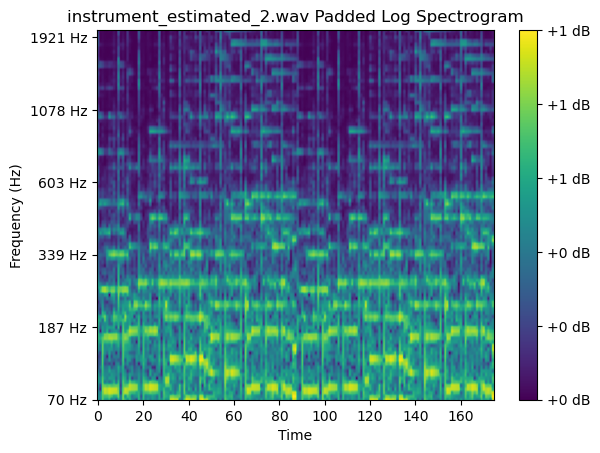

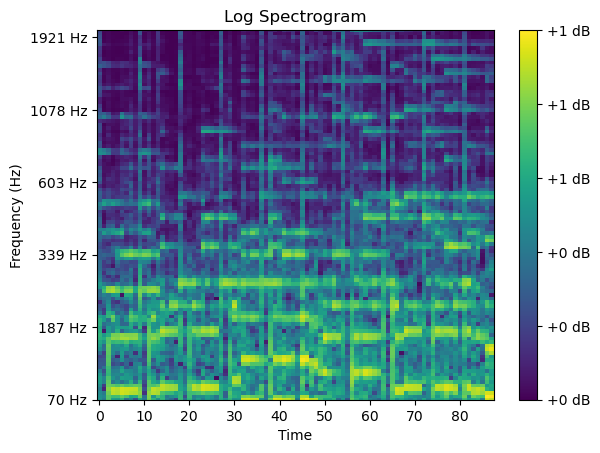

file name: instrument_estimated_3.wav
Log spectrogram shape: torch.Size([1, 103, 88])
num_segments: 0
padded segment shape: torch.Size([1, 103, 175])
instrument_estimated_3.wav_padded label: F# major (循環填充)


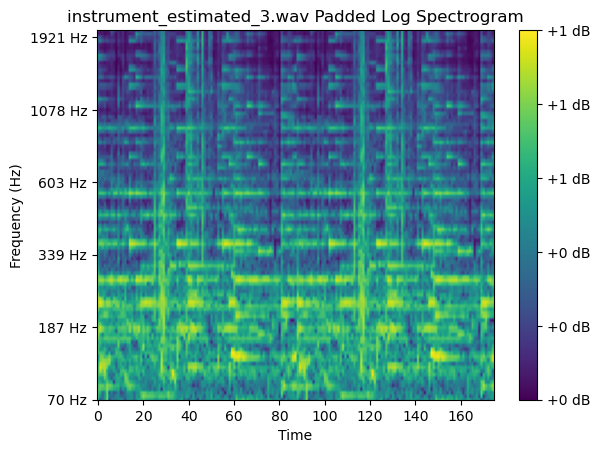

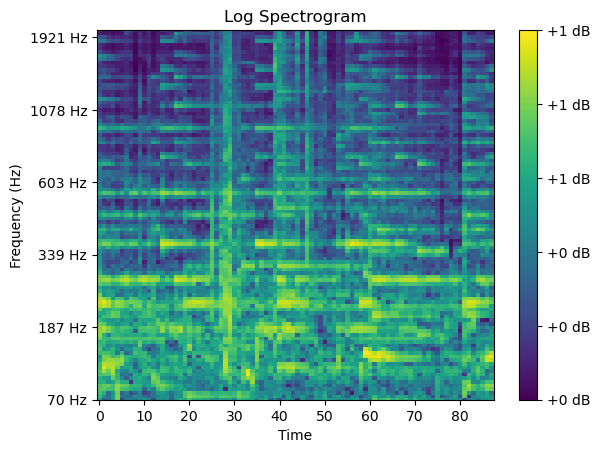

file name: instrument_estimated_4.wav
Log spectrogram shape: torch.Size([1, 103, 88])
num_segments: 0
padded segment shape: torch.Size([1, 103, 175])
instrument_estimated_4.wav_padded label: F# major (循環填充)
file name: instrument_estimated_5.wav
Log spectrogram shape: torch.Size([1, 103, 88])
num_segments: 0
padded segment shape: torch.Size([1, 103, 175])
instrument_estimated_5.wav_padded label: F# major (循環填充)
file name: instrument_estimated_6.wav
Log spectrogram shape: torch.Size([1, 103, 88])
num_segments: 0
padded segment shape: torch.Size([1, 103, 175])
instrument_estimated_6.wav_padded label: C# major (循環填充)
file name: instrument_estimated_7.wav
Log spectrogram shape: torch.Size([1, 103, 88])
num_segments: 0
padded segment shape: torch.Size([1, 103, 175])
instrument_estimated_7.wav_padded label: F# major (循環填充)
file name: instrument_estimated_8.wav
Log spectrogram shape: torch.Size([1, 103, 88])
num_segments: 0
padded segment shape: torch.Size([1, 103, 175])
instrument_estimated_8

In [3]:


if __name__ == '__main__':

    audio_folder = 'test_audio'
    labels = load_labels('test_tunebat.xlsx')
    hdf5_path = 'test_log_spectrograms_rtk.hdf5'

    print(f'labels: {labels}')


    # audio_files = [os.path.join(audio_folder, f) for f in os.listdir(audio_folder) if f.endswith('.wav')]
    # 从目录中获取所有.wav文件，并按文件名中的数字排序
    audio_files = [os.path.join(audio_folder, f) for f in sorted(os.listdir(audio_folder), key=numerical_sort) if f.endswith('.wav')]


    # # 处理每个音频文件并保存到 HDF5
    # for file_path in audio_files:
    #     save_mel_spec_and_labels_to_hdf5(file_path, labels, hdf5_path)
    save_log_spec_and_labels_to_hdf5(audio_files, labels, hdf5_path)
    # save_mel_spec_and_labels_to_hdf5(audio_files, labels, hdf5_path)
    print(f'spectrograms saved as {hdf5_path}.')
